# Introduction

## In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

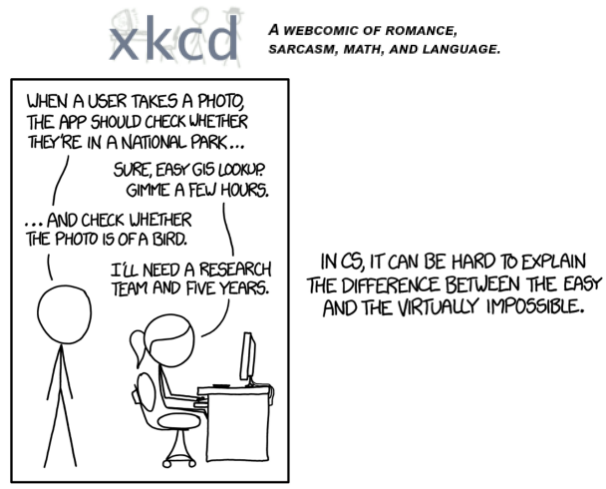

### But in this notebook, we are going to do exactly that.

# Downloading requirements

In [ ]:
#! pip install -q fastai fastbook duckduckgo_search ipywidgets

In [ ]:
%matplotlib inline 

In [ ]:
import fastbook
from pathlib import Path
from fastbook import *
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastcore.all import *
import shutil
fastbook.setup_book()

# Preparing training- and validation set

## Variable definitions

In [ ]:
model_name = "country_guesser"
img_amount = 47658 #images pr. category
img_quality = 224 #image quality in pixels
useCurrentTrainingData = True

prefix = "Image of "
category_types = [
    'China', 'India', 'United States', 'Indonesia', 'Pakistan',
    'Nigeria', 'Brazil', 'Bangladesh', 'Russia', 'Mexico',
    'Ethiopia', 'Philippines', 'Egypt', 'Vietnam', 'DR Congo',
    'Turkey', 'Iran', 'Germany', 'Thailand', 'United Kingdom',
    'France', 'Italy', 'Tanzania', 'South Africa', 'Myanmar',
    'Kenya', 'South Korea', 'Colombia', 'Spain', 'Argentina',
    'Uganda', 'Ukraine', 'Algeria', 'Sudan', 'Iraq',
    'Afghanistan', 'Poland', 'Canada', 'Morocco', 'Saudi Arabia',
    'Uzbekistan', 'Malaysia', 'Peru', 'Venezuela', 'Angola',
    'Ghana', 'Mozambique', 'Nepal', 'Yemen', 'Madagascar',
    'Cameroon', 'Côte d\'Ivoire', 'North Korea', 'Australia', 'Niger',
    'Sri Lanka', 'Burkina Faso', 'Mali', 'Romania', 'Malawi',
    'Chile', 'Kazakhstan', 'Zambia', 'Guatemala', 'Ecuador',
    'Syria', 'Netherlands', 'Senegal', 'Cambodia', 'Chad',
    'Somalia', 'Zimbabwe', 'Guinea', 'Rwanda', 'Benin',
    'Burundi', 'Tunisia', 'Bolivia', 'Belgium', 'Haiti',
    'Cuba', 'South Sudan', 'Dominican Republic', 'Czechia', 'Greece',
    'Jordan', 'Portugal', 'Azerbaijan', 'Sweden', 'Honduras',
    'United Arab Emirates', 'Hungary', 'Tajikistan', 'Belarus', 'Austria',
    'Papua New Guinea', 'Serbia', 'Israel', 'Switzerland', 'Togo',
    'Sierra Leone', 'Hong Kong', 'Laos', 'Paraguay', 'Bulgaria',
    'Libya', 'Lebanon', 'Nicaragua', 'Kyrgyzstan', 'El Salvador',
    'Turkmenistan', 'Singapore', 'Denmark', 'Finland', 'Congo',
    'Slovakia', 'Norway', 'Oman', 'State of Palestine', 'Costa Rica',
    'Liberia', 'Ireland', 'Central African Republic', 'New Zealand', 'Mauritania',
    'Panama', 'Kuwait', 'Croatia', 'Moldova', 'Georgia',
    'Eritrea', 'Uruguay', 'Bosnia and Herzegovina', 'Mongolia', 'Armenia',
    'Jamaica', 'Albania', 'Qatar', 'Lithuania', 'Namibia',
    'Gambia', 'Botswana', 'Gabon', 'Lesotho', 'North Macedonia',
    'Slovenia', 'Guinea-Bissau', 'Latvia', 'Bahrain', 'Equatorial Guinea',
    'Trinidad and Tobago', 'Estonia', 'Timor-Leste', 'Mauritius', 'Cyprus',
    'Eswatini', 'Djibouti', 'Fiji', 'Comoros', 'Guyana',
    'Bhutan', 'Solomon Islands', 'Macao', 'Montenegro', 'Luxembourg',
    'Suriname', 'Cabo Verde', 'Malta', 'Western Sahara', 'Brunei',
    'Bahamas', 'Maldives', 'Belize', 'Iceland', 'Barbados',
    'French Polynesia', 'Vanuatu', 'New Caledonia', 'São Tomé and Príncipe', 'Samoa',
    'Saint Lucia', 'Channel Islands', 'Guam', 'Curaçao', 'Kiribati',
    'Micronesia', 'Grenada', 'St. Vincent and Grenadines', 'Aruba', 'Tonga',
    'U.S. Virgin Islands', 'Seychelles', 'Antigua and Barbuda', 'Isle of Man', 'Andorra',
    'Dominica', 'Cayman Islands', 'Bermuda', 'Marshall Islands', 'Greenland',
    'Saint Kitts and Nevis', 'Northern Mariana Islands', 'American Samoa', 'Saint Pierre and Miquelon', 'Palau',
    'Tuvalu', 'San Marino', 'Monaco', 'Liechtenstein', 'Saint Helena',
    'Gibraltar', 'Nauru', 'Wallis and Futuna', 'Vatican City'
]
suffix = ""

trainingFolder = Path.cwd().parent / 'training_data'
modelFolder = Path.cwd().parent / 'trained_models'

## Info for upcomming training

In [91]:
ttl_imgs = round(len(category_types)*img_amount)
epochs = round(ttl_imgs ** 0.225)
print(f'Toral images: {ttl_imgs}')
print(f'Expected epochs: {epochs}')
print(f'Expected time to train: {round(ttl_imgs*0.005)} minutes')

Toral images: 47658
Expected epochs: 11
Expected time to train: 238 minutes


## Collecting images

In [ ]:
print(trainingFolder)

if useCurrentTrainingData == False:
    # Clear the contents of the categories' directories if it already exists
    if trainingFolder.exists():
        print(f"The '{trainingFolder}' dictionary already exists")
        shutil.rmtree(trainingFolder)
        print(f"Cleared the '{trainingFolder}' directory")

    # Create the categories' directories and subdirectories, and download images
    trainingFolder.mkdir(parents=True)
    for o in category_types:
        dest = (trainingFolder/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{prefix}{o}{suffix}", max_images=img_amount)
        download_images(dest, urls=results)
        print(f"Created new folder for: '{prefix}{o}{suffix}', and downloaded the images")

if trainingFolder.exists():
    print('All folders have been created successfully')
else:
    print(f"Something fucked up. The directory: '{trainingFolder}' does not exist")

/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Image-recognition/Training-data
All folders have been created successfully


## Unlinking failed images

In [71]:
fns = get_image_files(trainingFolder)

failed = verify_images(fns)
print(f'Failed images: {len(failed)}')

failed.map(Path.unlink)
print('Unlinking complete')

print(f'Successful images: {len(fns)} ready for training')

Failed images: 0
Unlinking complete
Successful images: 49976 ready for training


In [72]:
categories = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(size=img_quality, method='squish'))

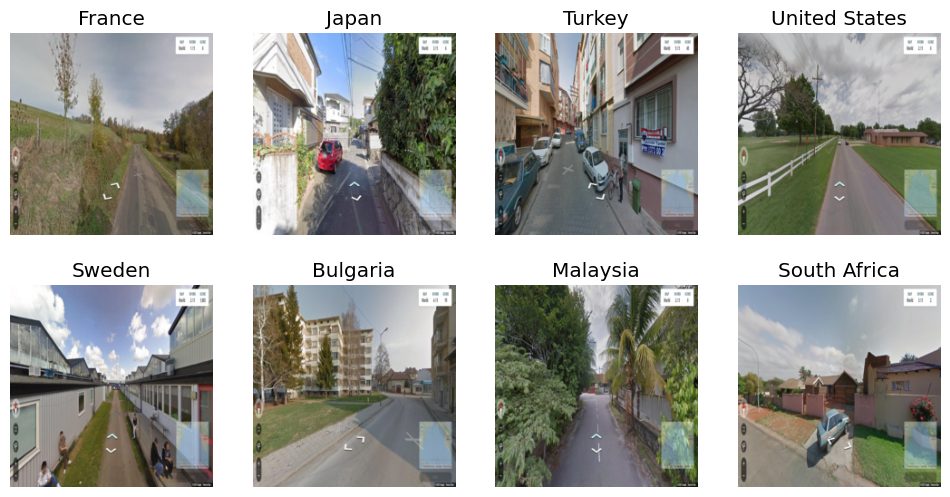

In [73]:
dls = categories.dataloaders(trainingFolder)
dls.valid.show_batch(max_n=8, nrows=2, unique=False)

## Non-augmented or resized image example

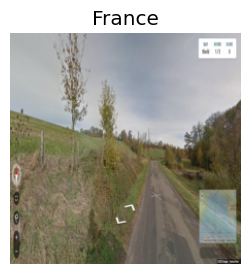

In [74]:
dls = categories.dataloaders(trainingFolder)
dls.valid.show_batch(max_n=1, nrows=1, unique=True)

## RandomResizedCrop examples

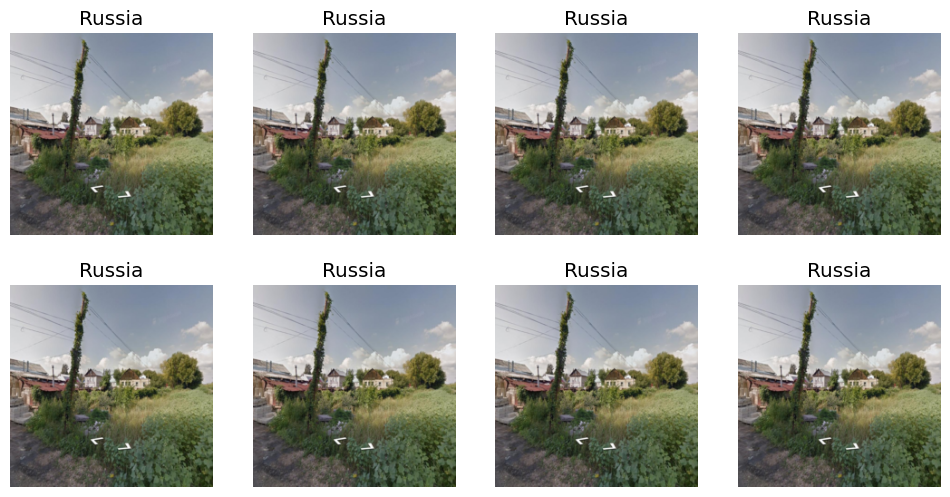

In [75]:
categories = categories.new(item_tfms=RandomResizedCrop(size=img_quality, min_scale=0.55))
dls = categories.dataloaders(trainingFolder)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## RandomResizedCrop & transform augmentation

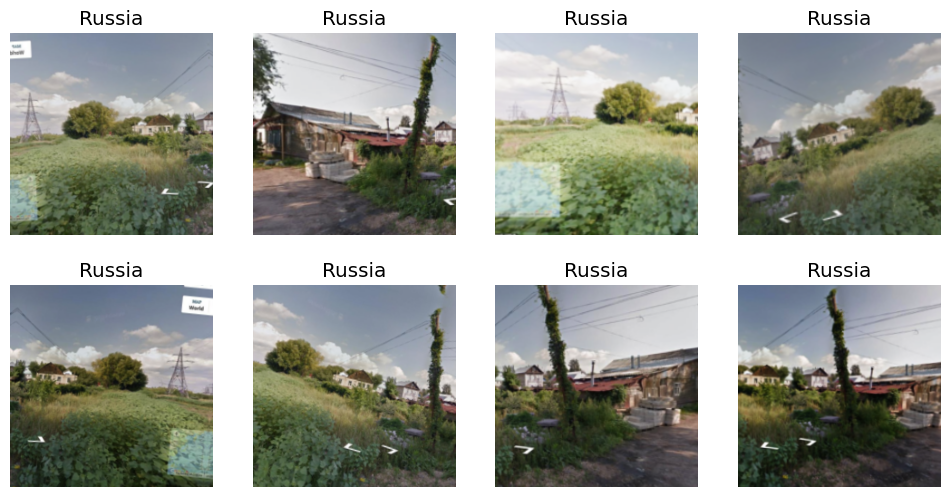

In [76]:
categories = categories.new(item_tfms=Resize(size=img_quality), 
                batch_tfms=[Flip(), Rotate(max_deg=18), Zoom(min_zoom=1.0, max_zoom=1.20), 
                Brightness(max_lighting=0.3), Contrast(max_lighting=0.25)])
dls = categories.dataloaders(trainingFolder)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training

In [77]:
print(f'Training for: {epochs} epochs')
print(f'Expected time to train: {round(ttl_imgs*0.005)} minutes')
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs)

Training for: 11 epochs


epoch,train_loss,valid_loss,error_rate,time
0,3.369581,2.733623,0.659530,15:40


epoch,train_loss,valid_loss,error_rate,time
0,2.657307,2.216843,0.562381,19:02
1,2.347239,1.960401,0.515158,19:31
2,2.109422,1.796575,0.473437,34:11
3,2.034394,1.698673,0.456328,18:44
4,1.854934,1.562971,0.423112,21:36
5,1.759360,1.496299,0.412506,24:56
6,1.612152,1.445414,0.401701,22:14
7,1.499232,1.416001,0.387094,18:05
8,1.374815,1.378667,0.382591,18:06
9,1.353508,1.362119,0.375188,18:06


# Measureing where the model fails to interpret images correctly

## Confusion matrix

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/interpret.py:133: RuntimeWarning: invalid value encountered in divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


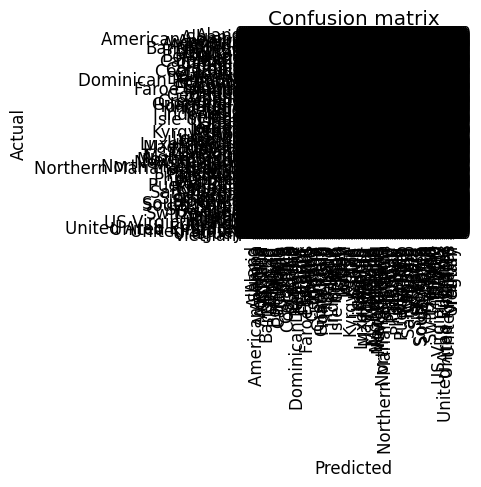

In [78]:
interp = ClassificationInterpretation.from_learner(learn)

if len(category_types)<=50:
    interp.plot_confusion_matrix(normalize=True, norm_dec=2)

## Classifications with the highest loss

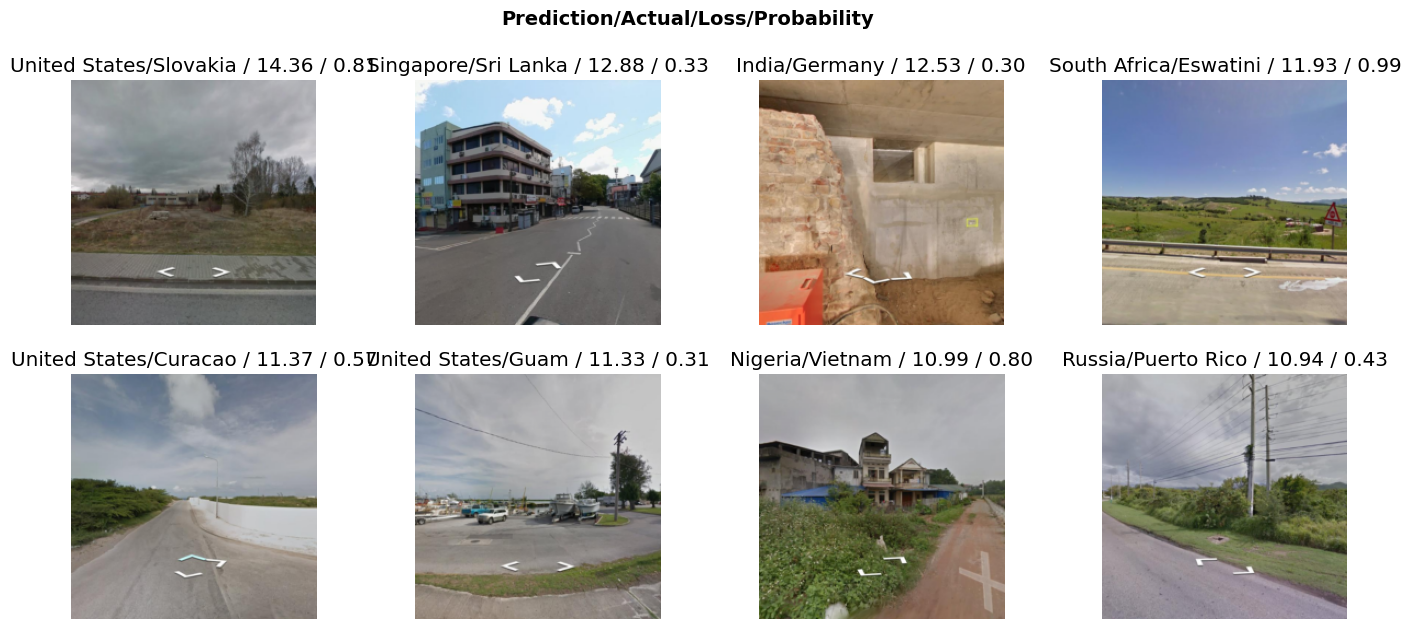

In [79]:
interp.plot_top_losses(8, nrows=2, figsize=(17, 7))

## Data-cleansing (optional)

In [80]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [81]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,category in cleaner.change(): shutil.move(str(cleaner.fns[idx]), trainingFolder/category)

# Exporting our model

In [82]:
learn.export(modelFolder / f'{model_name}.pkl')
modelFolder.ls(file_exts=".pkl")

(#5) [Path('/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/countryGuesser.pkl'),Path('/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/animalClassifier.pkl'),Path('/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/leagueChampionClassifier.pkl'),Path('/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/politicianClassifier.pkl'),Path('/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/test.pkl')]

# Testing our model with widgets

In [83]:
modelPath = modelFolder / f'{model_name}.pkl'
print(modelPath)

learn_inf = load_learner(modelPath)
learn_inf

/Users/victor/Documents/GitHub/VS-Code/Side-Projects/Trained-models/countryGuesser.pkl


In [84]:
#hide_output
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(448,448))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred} | Probability: {probs[pred_idx]:.02f}'

btn_run.on_click(on_click_classify)

VBox([btn_upload, btn_run, out_pl, lbl_pred])